In [1]:
import os
from tqdm.notebook import trange, tqdm

# Statistics / Analsyis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy
import pandas as pd
import cv2
import librosa
from scipy.signal import find_peaks
import sklearn
from scipy.ndimage import convolve
import scipy
import random

# Machine Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SpatialDropout2D, BatchNormalization, Dropout
import seaborn as sns


C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%load_ext tensorboard

In [2]:
DATA_FOLDER = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\ML DATABASE'
INDV_FILES = [os.path.join(DATA_FOLDER, path) for path in os.listdir(DATA_FOLDER)]
MAX_CATEGORY_FILES = 1500

noise_path1 = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\More'
noise_path2 = r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Noise'

label_types = ['Noise', 'Blue_A', 'Blue_B', 'Humphback']
label_n = {'Noise': 0, 'Blue_A': 1, 'Blue_B':2, 'Humphback':3}

label_types_paths = {key: [] for key in label_types}

IMAGES = []
LABELS = []

In [4]:
noise1  = [os.path.join(noise_path1, i) for i in os.listdir(noise_path1)]
noise2 = [os.path.join(noise_path2, i) for i in os.listdir(noise_path2)]

random.shuffle(noise1)
random.shuffle(noise2)

noise1 = noise1[:int(MAX_CATEGORY_FILES*1/2)]
noise2 = noise2[:int(MAX_CATEGORY_FILES*1/2)]

NOISE_SAMPES = noise1 + noise2

label_types_paths['Noise'] = NOISE_SAMPES

In [5]:
for indv_file in tqdm(INDV_FILES):
    
    for label in label_types:
        if label!='Noise':
            try:
                p = os.path.join(indv_file, label)
                for im_name in os.listdir(p):
                    label_types_paths[label].append(os.path.join(p, im_name))
            except:
                pass

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
for key in tqdm(label_types):
    random.shuffle(label_types_paths[key])
    if key!='Noise':
        label_types_paths[key] = label_types_paths[key][:MAX_CATEGORY_FILES]
    for elem in label_types_paths[key]:
        IMAGES.append(np.flipud(plt.imread(elem)[:,:,:3]))
        LABELS.append(label_n[key])

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
tf.__version__

'2.10.1'

In [11]:
for label in label_types:
    print("{}: {} data samples".format(label, len(label_types_paths[label])))

Noise: 1196 data samples
Blue_A: 1183 data samples
Blue_B: 996 data samples
Humphback: 1500 data samples


In [12]:
IMAGES = np.array(IMAGES)
LABELS = np.array(LABELS)

randomize = np.arange(len(IMAGES))
np.random.shuffle(randomize)
IMAGES = IMAGES[randomize]
LABELS = LABELS[randomize]

for c, im in enumerate(IMAGES):
    im  = (im - np.min(im)) / (np.max(im) - np.min(im))
    IMAGES[c] = im

In [13]:
train_data = IMAGES[:int(0.7*len(IMAGES))]
train_labels = LABELS[:int(0.7*len(IMAGES))]

test_data = IMAGES[int(0.7*len(IMAGES)):]
test_labels = LABELS[int(0.7*len(IMAGES)):]

In [3]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(SpatialDropout2D(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(SpatialDropout2D(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(SpatialDropout2D(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 spatial_dropout2d (SpatialD  (None, 222, 222, 64)     0         
 ropout2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                        

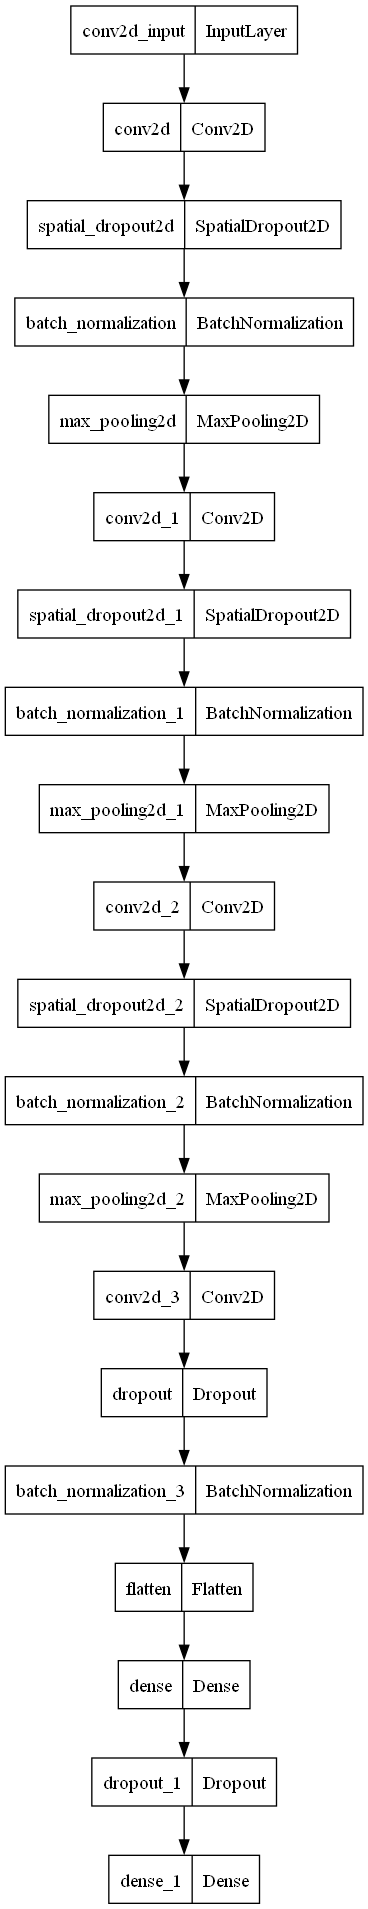

In [5]:
tf.keras.utils.plot_model(model)

In [11]:
!pip install pydot

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
import datetime

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
history = model.fit(train_data, train_labels, epochs=15, batch_size = 32, validation_data=(test_data, test_labels), callbacks=[tensorboard_callback])

Epoch 1/15
107/107 [==============================] - 14s 87ms/step - loss: 0.3277 - accuracy: 0.9056 - val_loss: 2.0717 - val_accuracy: 0.3753
Epoch 2/15
107/107 [==============================] - 8s 72ms/step - loss: 0.1305 - accuracy: 0.9590 - val_loss: 4.5563 - val_accuracy: 0.2269
Epoch 3/15
107/107 [==============================] - 7s 68ms/step - loss: 0.1005 - accuracy: 0.9642 - val_loss: 2.1806 - val_accuracy: 0.2365
Epoch 4/15
107/107 [==============================] - 7s 68ms/step - loss: 0.1007 - accuracy: 0.9660 - val_loss: 0.1923 - val_accuracy: 0.9316
Epoch 5/15
107/107 [==============================] - 7s 70ms/step - loss: 0.0667 - accuracy: 0.9768 - val_loss: 0.1215 - val_accuracy: 0.9467
Epoch 6/15
107/107 [==============================] - 7s 68ms/step - loss: 0.0681 - accuracy: 0.9754 - val_loss: 0.0728 - val_accuracy: 0.9713
Epoch 7/15
107/107 [==============================] - 7s 69ms/step - loss: 0.0536 - accuracy: 0.9786 - val_loss: 0.0537 - val_accuracy: 0.978

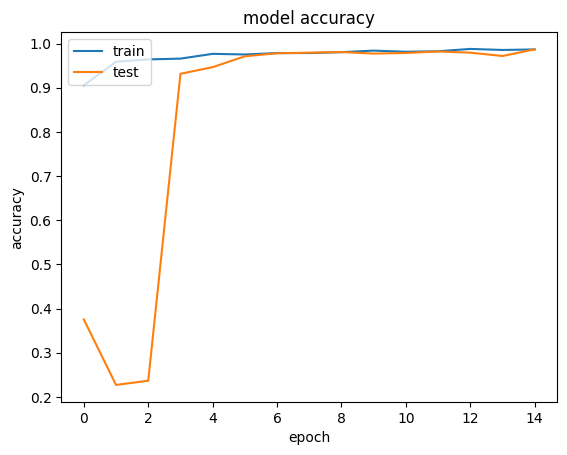

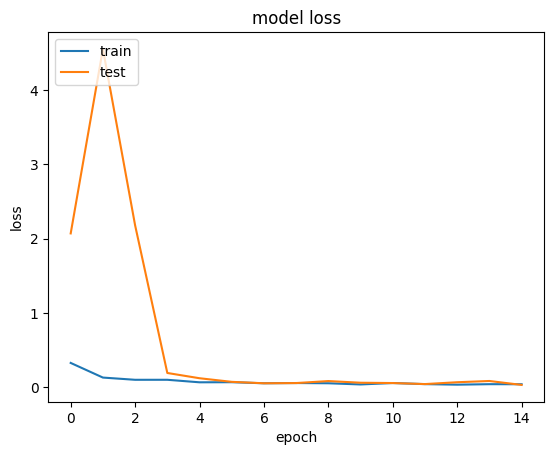

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model.evaluate(test_data, test_labels)

46/46 [==============================] - 1s 18ms/step - loss: 0.0315 - accuracy: 0.9870


[0.031487949192523956, 0.9870129823684692]

In [24]:
preds = model.predict(test_data)

46/46 [==============================] - 1s 17ms/step


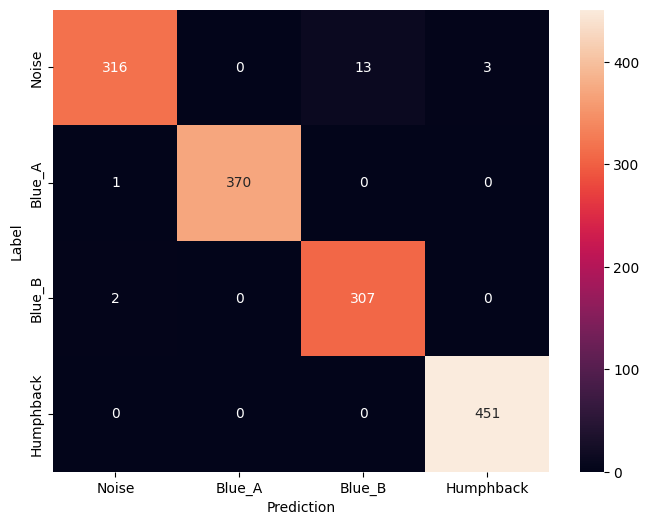

In [25]:
y_pred = tf.argmax(preds, axis=1)
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_types,
            yticklabels=label_types,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [26]:
model.save('saved_model/multimodel-v3')

INFO:tensorflow:Assets written to: saved_model/multimodel-v3\assets


INFO:tensorflow:Assets written to: saved_model/multimodel-v3\assets
